In [46]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import statsmodels.formula.api as smf
import sklearn.metrics as metrics
import sklearn.linear_model as sklm
import matplotlib.pyplot as plt

In [47]:
# Pull in remote dataset from UCI ML repo
raw_data = fetch_ucirepo(id=849)

In [48]:
# Create flat table
raw_df: pd.DataFrame = raw_data.data.features.merge(raw_data.data.targets,
                                                    how='outer',
                                                    left_index=True,
                                                    right_index=True)

# Relabeling with friendly column headers
new_colnames = ["datetime",
                "temperature",
                "humidity",
                "wind_speed",
                "general_diffuse_flows",
                "diffuse_flows",
                "zone_1_power",
                "zone_2_power",
                "zone_3_power"]

colname_updates = {orig_colnames: new_colnames for orig_colnames,
                   new_colnames in zip(raw_df.columns, new_colnames)}

tetoun_power: pd.DataFrame = raw_df.rename(columns=colname_updates)

# Feature Engineering
tetoun_power["datetime"] = pd.to_datetime(tetoun_power["datetime"])

tetoun_power["total_power"] = tetoun_power["zone_1_power"] + \
    tetoun_power["zone_2_power"] + tetoun_power["zone_3_power"]

tetoun_power = tetoun_power.assign(
    year=tetoun_power["datetime"].dt.year,
    month=tetoun_power["datetime"].dt.month,
    day=tetoun_power["datetime"].dt.day,
    hour=tetoun_power["datetime"].dt.hour,
    minute=tetoun_power["datetime"].dt.minute,
    day_of_week=tetoun_power["datetime"].dt.dayofweek,
    day_of_year=tetoun_power["datetime"].dt.dayofyear,
    weekofyear=tetoun_power["datetime"].dt.isocalendar().week,
    zone_1_2wma=tetoun_power["zone_1_power"].rolling(window=72).mean(),
    zone_1_1mma=tetoun_power["zone_1_power"].rolling(window=144).mean(),
    zone_1_2mma=tetoun_power["zone_1_power"].rolling(window=288).mean(),
    zone_1_3mma=tetoun_power["zone_1_power"].rolling(window=432).mean(),
    zone_1_6mma=tetoun_power["zone_1_power"].rolling(window=864).mean(),
    zone_2_6mma=tetoun_power["zone_2_power"].rolling(window=864).mean(),
    zone_3_6mma=tetoun_power["zone_3_power"].rolling(window=864).mean(),
    total_power_6mma=tetoun_power["total_power"].rolling(window=864).mean()
)

In [49]:
tetoun_power.head()

,datetime,temperature,humidity,wind_speed,general_diffuse_flows,diffuse_flows,zone_1_power,zone_2_power,zone_3_power,total_power,...,day_of_year,weekofyear,zone_1_2wma,zone_1_1mma,zone_1_2mma,zone_1_3mma,zone_1_6mma,zone_2_6mma,zone_3_6mma,total_power_6mma
0,2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386,70425.53544,...,1,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434,69320.84387,...,1,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373,67803.22193,...,1,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711,65489.23209,...,1,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964,63650.44627,...,1,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
tetoun_power.loc[tetoun_power["month"] == 1].shape[0]/31/2

72.0

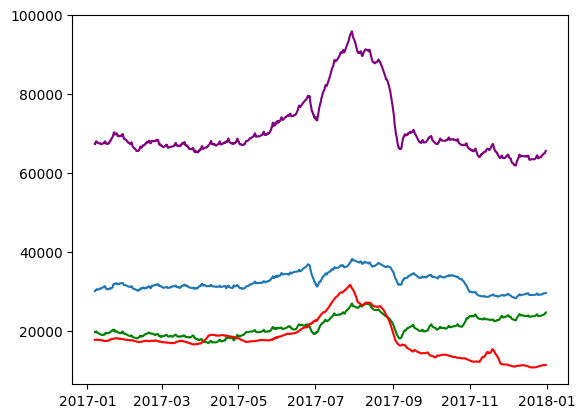

In [51]:
fig, ax = plt.subplots()

ax.plot(tetoun_power["datetime"], tetoun_power["zone_1_6mma"])
ax.plot(tetoun_power["datetime"], tetoun_power["zone_2_6mma"], color="green")
ax.plot(tetoun_power["datetime"], tetoun_power["zone_3_6mma"], color="red")
ax.plot(tetoun_power["datetime"],
        tetoun_power["total_power_6mma"], color="purple")

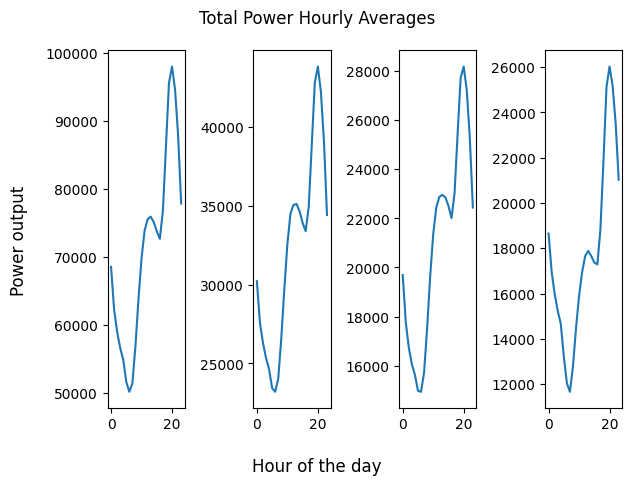

In [52]:
tp_hourly_avg = tetoun_power.groupby("hour").agg({"total_power": "mean"})
z1_hourly_avg = tetoun_power.groupby("hour").agg({"zone_1_power": "mean"})
z2_hourly_avg = tetoun_power.groupby("hour").agg({"zone_2_power": "mean"})
z3_hourly_avg = tetoun_power.groupby("hour").agg({"zone_3_power": "mean"})

fig, ax = plt.subplots(1, 4)

ax[0].plot(np.arange(0, 24, 1), tp_hourly_avg["total_power"])
ax[1].plot(np.arange(0, 24, 1), z1_hourly_avg["zone_1_power"])
ax[2].plot(np.arange(0, 24, 1), z2_hourly_avg["zone_2_power"])
ax[3].plot(np.arange(0, 24, 1), z3_hourly_avg["zone_3_power"])

fig.suptitle("Total Power Hourly Averages")
fig.supylabel("Power output")
fig.supxlabel("Hour of the day")
fig.tight_layout()
plt.show()

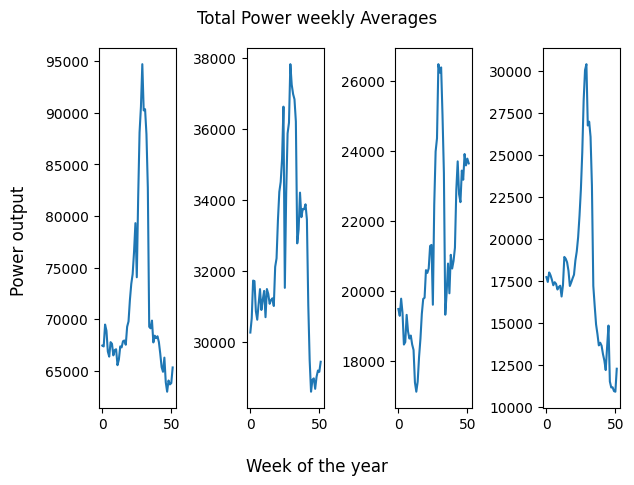

In [53]:
tp_weekly_avg = tetoun_power.groupby("weekofyear").agg({"total_power": "mean"})
z1_weekly_avg = tetoun_power.groupby(
    "weekofyear").agg({"zone_1_power": "mean"})
z2_weekly_avg = tetoun_power.groupby(
    "weekofyear").agg({"zone_2_power": "mean"})
z3_weekly_avg = tetoun_power.groupby(
    "weekofyear").agg({"zone_3_power": "mean"})

fig, ax = plt.subplots(1, 4)

ax[0].plot(np.arange(0, 52, 1), tp_weekly_avg["total_power"])
ax[1].plot(np.arange(0, 52, 1), z1_weekly_avg["zone_1_power"])
ax[2].plot(np.arange(0, 52, 1), z2_weekly_avg["zone_2_power"])
ax[3].plot(np.arange(0, 52, 1), z3_weekly_avg["zone_3_power"])

fig.suptitle("Total Power weekly Averages")
fig.supylabel("Power output")
fig.supxlabel("Week of the year")
fig.tight_layout()
plt.show()

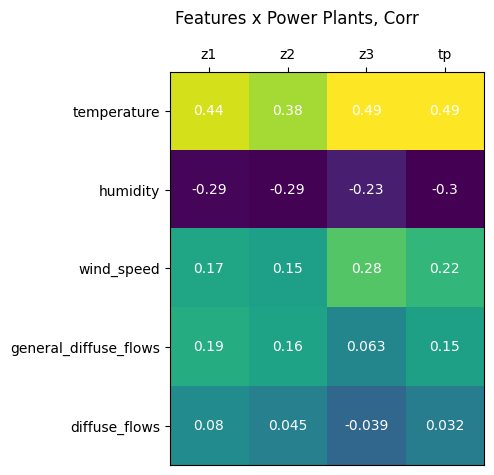

In [54]:
common_feats = ["temperature",
                "humidity",
                "wind_speed",
                "general_diffuse_flows",
                "diffuse_flows"]

tp_corr = tetoun_power[common_feats+["total_power"]] \
    .corr().loc[pd.Index(common_feats), "total_power"]

z1_corr = tetoun_power[common_feats+["zone_1_power"]] \
    .corr().loc[pd.Index(common_feats), "zone_1_power"]

z2_corr = tetoun_power[common_feats+["zone_2_power"]] \
    .corr().loc[pd.Index(common_feats), "zone_2_power"]

z3_corr = tetoun_power[common_feats+["zone_3_power"]] \
    .corr().loc[pd.Index(common_feats), "zone_3_power"]

corr_df = pd.DataFrame({"z1": z1_corr, "z2": z2_corr,
                       "z3": z3_corr, "tp": tp_corr})

fig, ax = plt.subplots()

ax.imshow(corr_df)

ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax.set_xticks(np.arange(corr_df.shape[1]), labels=corr_df.columns)
ax.set_yticks(np.arange(corr_df.shape[0]), labels=common_feats)

# Loop over data dimensions and create text annotations.
for i in range(corr_df.shape[0]):
    for j in range(corr_df.shape[1]):
        text = ax.text(j, i, f"{corr_df.iloc[i, j]:.2}",
                       ha="center", va="center", color="w")

plt.suptitle("Features x Power Plants, Corr")
plt.tight_layout()
plt.show()

The table above explores basic correlations between the predictors and each of the power zones as well as with the combination of all three zones.

Without additional analysis, it appears that zones 1 and 2 are most similar to eachother and have a greater impact on the total output than Zone 3.

In [55]:
# Dataframe of Cosine Similarities
cs_df = pd.DataFrame(metrics.pairwise.cosine_similarity(corr_df.T))
cs_df.columns = ["z1", "z2", "z3", "tp"]
cs_df.index = ["z1", "z2", "z3", "tp"]

cs_df

,z1,z2,z3,tp
z1,1.000000,0.995680,0.935337,0.990414
z2,0.995680,1.000000,0.936256,0.990187
z3,0.935337,0.936256,1.000000,0.974533
tp,0.990414,0.990187,0.974533,1.000000


In [56]:
tetoun_power[["zone_1_power", "zone_2_power",
              "zone_3_power", "total_power"]].corr()

,zone_1_power,zone_2_power,zone_3_power,total_power
zone_1_power,1.000000,0.834519,0.750733,0.959146
zone_2_power,0.834519,1.000000,0.570932,0.871069
zone_3_power,0.750733,0.570932,1.000000,0.871777
total_power,0.959146,0.871069,0.871777,1.000000


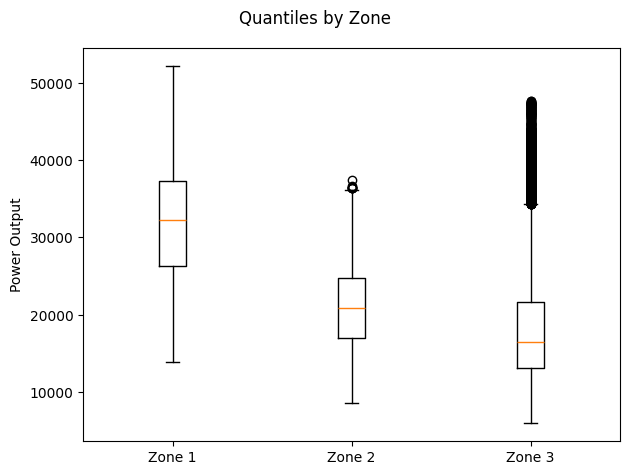

In [57]:
fig, ax = plt.subplots()

ax.boxplot(tetoun_power["zone_1_power"], positions=[1])
ax.boxplot(tetoun_power["zone_2_power"], positions=[2])
ax.boxplot(tetoun_power["zone_3_power"], positions=[3])

ax.set_xticklabels(["Zone 1", "Zone 2", "Zone 3"])
ax.set_ylabel("Power Output")

fig.suptitle("Quantiles by Zone")
fig.tight_layout()
plt.show()

In [58]:
tetoun_power.columns

Index(['datetime', 'temperature', 'humidity', 'wind_speed',
       'general_diffuse_flows', 'diffuse_flows', 'zone_1_power',
       'zone_2_power', 'zone_3_power', 'total_power', 'year', 'month', 'day',
       'hour', 'minute', 'day_of_week', 'day_of_year', 'weekofyear',
       'zone_1_2wma', 'zone_1_1mma', 'zone_1_2mma', 'zone_1_3mma',
       'zone_1_6mma', 'zone_2_6mma', 'zone_3_6mma', 'total_power_6mma'],
      dtype='object')

In [59]:
# Multiple Linear Regression: Zone 1
mv_lm_zone_1 = smf.ols(formula="zone_1_power ~ \
                       month + day_of_week + hour + \
                       temperature + humidity + wind_speed + \
                       general_diffuse_flows + diffuse_flows",
                       data=tetoun_power).fit()


# Multiple Linear Regression: Zone 2
mv_lm_zone_2 = smf.ols(formula="zone_2_power ~ \
                       month + day_of_week + hour + \
                       temperature + humidity + wind_speed + \
                       general_diffuse_flows + diffuse_flows",
                       data=tetoun_power).fit()


# Multiple Linear Regression: Zone 3
mv_lm_zone_3 = smf.ols(formula="zone_3_power ~ \
                       month + day_of_week + hour + \
                       temperature + humidity + wind_speed + \
                       general_diffuse_flows + diffuse_flows",
                       data=tetoun_power).fit()

# Multiple Linear Regression: Total Power
mv_lm_total_power = smf.ols(formula="total_power ~ \
                       month + day_of_week + hour + \
                       temperature + humidity + wind_speed + \
                       general_diffuse_flows + diffuse_flows",
                       data=tetoun_power).fit()

print(mv_lm_zone_1.summary2())

                        Results: Ordinary least squares
Model:                  OLS                 Adj. R-squared:        0.644       
Dependent Variable:     zone_1_power        AIC:                   1024697.0003
Date:                   2024-10-17 00:53    BIC:                   1024776.8030
No. Observations:       52416               Log-Likelihood:        -5.1234e+05 
Df Model:               8                   F-statistic:           1.186e+04   
Df Residuals:           52407               Prob (F-statistic):    0.00        
R-squared:              0.644               Scale:                 1.8097e+07  
-------------------------------------------------------------------------------
                        Coef.    Std.Err.    t     P>|t|    [0.025     0.975]  
-------------------------------------------------------------------------------
Intercept             18313.9454 152.3441 120.2144 0.0000 18015.3496 18612.5412
month                  -253.2628   5.7887 -43.7515 0.0000  -264.

In [60]:
print(mv_lm_zone_2.summary2())

                        Results: Ordinary least squares
Model:                   OLS                 Adj. R-squared:        0.594      
Dependent Variable:      zone_2_power        AIC:                   998474.7431
Date:                    2024-10-17 00:53    BIC:                   998554.5458
No. Observations:        52416               Log-Likelihood:        -4.9923e+05
Df Model:                8                   F-statistic:           9603.      
Df Residuals:            52407               Prob (F-statistic):    0.00       
R-squared:               0.594               Scale:                 1.0974e+07 
-------------------------------------------------------------------------------
                        Coef.    Std.Err.    t     P>|t|    [0.025     0.975]  
-------------------------------------------------------------------------------
Intercept             13679.7751 118.6295 115.3151 0.0000 13447.2601 13912.2901
month                   406.3028   4.5076  90.1371 0.0000   397.

In [61]:
print(mv_lm_zone_3.summary2())

                       Results: Ordinary least squares
Model:                  OLS                Adj. R-squared:       0.601       
Dependent Variable:     zone_3_power       AIC:                  1022897.6753
Date:                   2024-10-17 00:53   BIC:                  1022977.4780
No. Observations:       52416              Log-Likelihood:       -5.1144e+05 
Df Model:               8                  F-statistic:          9880.       
Df Residuals:           52407              Prob (F-statistic):   0.00        
R-squared:              0.601              Scale:                1.7487e+07  
-----------------------------------------------------------------------------
                        Coef.   Std.Err.     t     P>|t|    [0.025    0.975] 
-----------------------------------------------------------------------------
Intercept             5947.5687 149.7516   39.7162 0.0000 5654.0542 6241.0831
month                 -871.3437   5.6902 -153.1316 0.0000 -882.4965 -860.1909
day_of_we

In [62]:
print(mv_lm_total_power.summary())

                            OLS Regression Results                            
Dep. Variable:            total_power   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                 1.133e+04
Date:                Thu, 17 Oct 2024   Prob (F-statistic):               0.00
Time:                        00:53:32   Log-Likelihood:            -5.5908e+05
No. Observations:               52416   AIC:                         1.118e+06
Df Residuals:                   52407   BIC:                         1.118e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              3.794e+

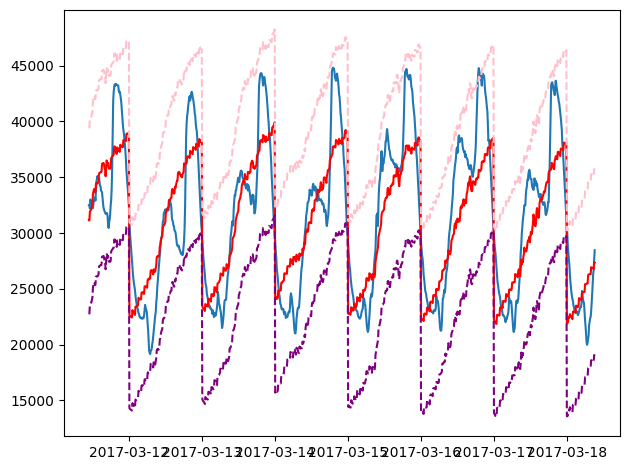

In [63]:
sample = tetoun_power[10000:11000]

# pred = mv_lm_zone_1.predict(sample)
pred = mv_lm_zone_1.get_prediction(sample).summary_frame()

fig, ax = plt.subplots()

ax.plot(sample["datetime"], sample["zone_1_power"])
ax.plot(sample["datetime"], pred["mean"], color="red")
ax.plot(sample["datetime"], pred["obs_ci_lower"],
        linestyle='--', color="purple")
ax.plot(sample["datetime"], pred["obs_ci_upper"], linestyle='--', color="pink")

fig.tight_layout()

plt.show()

In [64]:
# Accuracy measures for Zone 1 MV LM
metrics.mean_absolute_percentage_error(tetoun_power["zone_1_power"],
                                       mv_lm_zone_1.predict(tetoun_power))

np.float64(0.10842811026307334)

In [65]:
# Fitting a Ridge Regression
y = tetoun_power["zone_1_power"]
X = tetoun_power[["month", "day_of_week", "hour", "temperature",
                  "humidity", "wind_speed", "general_diffuse_flows", "diffuse_flows"]]

z1_rr = sklm.RidgeCV(alphas=list(np.linspace(100, 1000, num=10000))).fit(X, y)
# z1_rr = sklm.RidgeCV(alphas=[1.0e-3]).fit(X, y)

z1_rr.score(X, y)


0.6441247837446178

In [66]:
# Learned Regularization parameter
z1_rr.alpha_

np.float64(315.66156615661566)

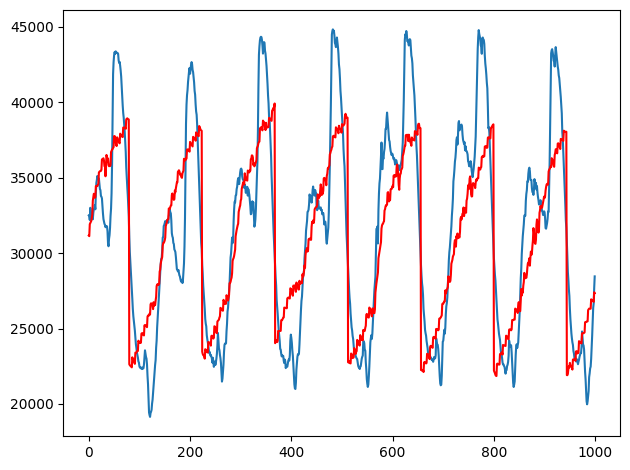

In [67]:
sample = X[10000:11000]

# pred = mv_lm_zone_1.predict(sample)
pred = z1_rr.predict(sample)
output_space = np.linspace(0,  999, num=1000)

fig, ax = plt.subplots()

ax.plot(output_space, tetoun_power.loc[10000:10999, "zone_1_power"])
ax.plot(output_space, pred, color="red")

fig.tight_layout()

plt.show()

In [68]:
# Calculate the log-likelihood
def log_likelihood(model, y, X):
    k = len(model.coef_) + 1 
    n = len(y)

    residuals = y - model.predict(X)
    mse = metrics.mean_squared_error(y, model.predict(X))
    return k, -n/2 * np.log(2*np.pi) - n/2 * np.log(mse) - 1/(2*mse) * np.sum(residuals**2)

def aic(model, y, X):
    k, ll = log_likelihood(model, y, X)
    return 2*k - 2*ll

In [69]:
# Comparing AIC

print(f"AIC RR: {aic(z1_rr, y, X)}")
print(f"AIC MVLM: {mv_lm_zone_1.aic}")



AIC RR: 1024697.0046720345
AIC MVLM: 1024697.000258856


In [70]:
pred_zone_sums = \
    mv_lm_zone_1.predict(tetoun_power) + \
    mv_lm_zone_1.predict(tetoun_power) + \
    mv_lm_zone_1.predict(tetoun_power)

pred_tp = mv_lm_total_power.predict(tetoun_power)

print(metrics.mean_absolute_percentage_error(tetoun_power["total_power"],
                                             pred_zone_sums))

print(metrics.mean_absolute_percentage_error(tetoun_power["total_power"],
                                             pred_tp))

print()
print(metrics.explained_variance_score(tetoun_power["total_power"],
                                       pred_zone_sums))

print(metrics.explained_variance_score(tetoun_power["total_power"],
                                       pred_tp))

print()
print(np.sqrt(metrics.mean_squared_error(tetoun_power["total_power"],
                                         pred_zone_sums)))

print(np.sqrt(metrics.mean_squared_error(tetoun_power["total_power"],
                                         pred_tp)))

0.3980473224893352
0.11916965346437913

0.5766902339452613
0.6336334883045881

28118.741640566157
10376.33746079026


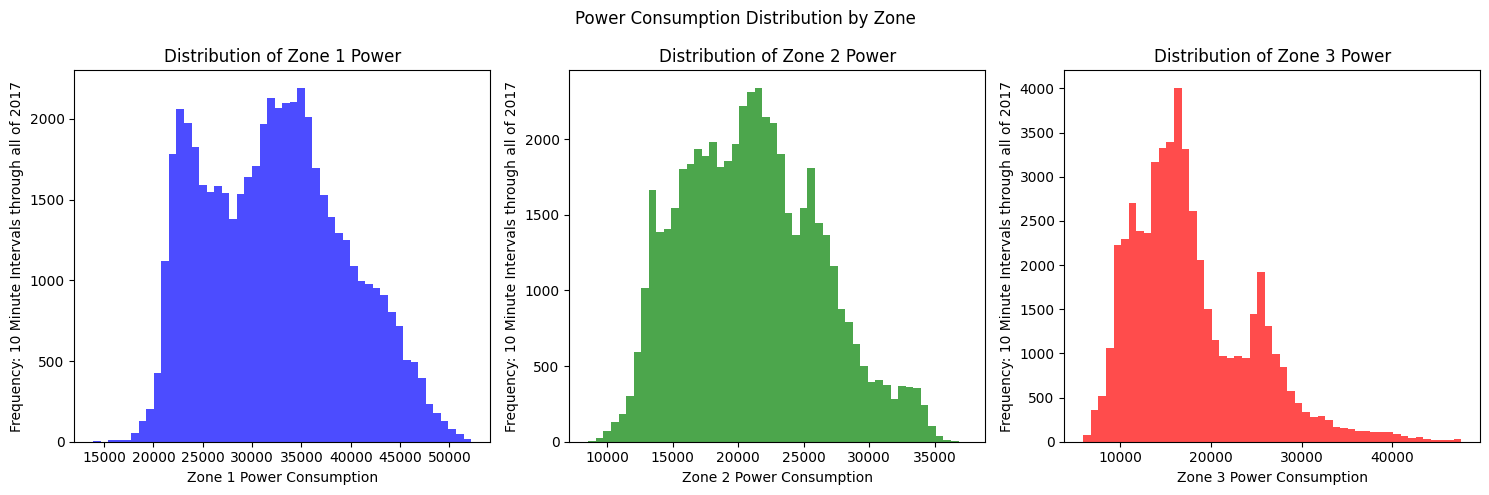

In [71]:
# Create a distribution chart for each power zone
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Distribution for Zone 1 Power
ax[0].hist(tetoun_power["zone_1_power"], bins=50, alpha=0.7, color='blue')
ax[0].set_title('Distribution of Zone 1 Power')
ax[0].set_xlabel('Zone 1 Power Consumption')
ax[0].set_ylabel('Frequency: 10 Minute Intervals through all of 2017')

# Distribution for Zone 2 Power
ax[1].hist(tetoun_power["zone_2_power"], bins=50, alpha=0.7, color='green')
ax[1].set_title('Distribution of Zone 2 Power')
ax[1].set_xlabel('Zone 2 Power Consumption')
ax[1].set_ylabel('Frequency: 10 Minute Intervals through all of 2017')

# Distribution for Zone 3 Power
ax[2].hist(tetoun_power["zone_3_power"], bins=50, alpha=0.7, color='red')
ax[2].set_title('Distribution of Zone 3 Power')
ax[2].set_xlabel('Zone 3 Power Consumption')
ax[2].set_ylabel('Frequency: 10 Minute Intervals through all of 2017')

fig.suptitle('Power Consumption Distribution by Zone')
plt.tight_layout()
plt.show()

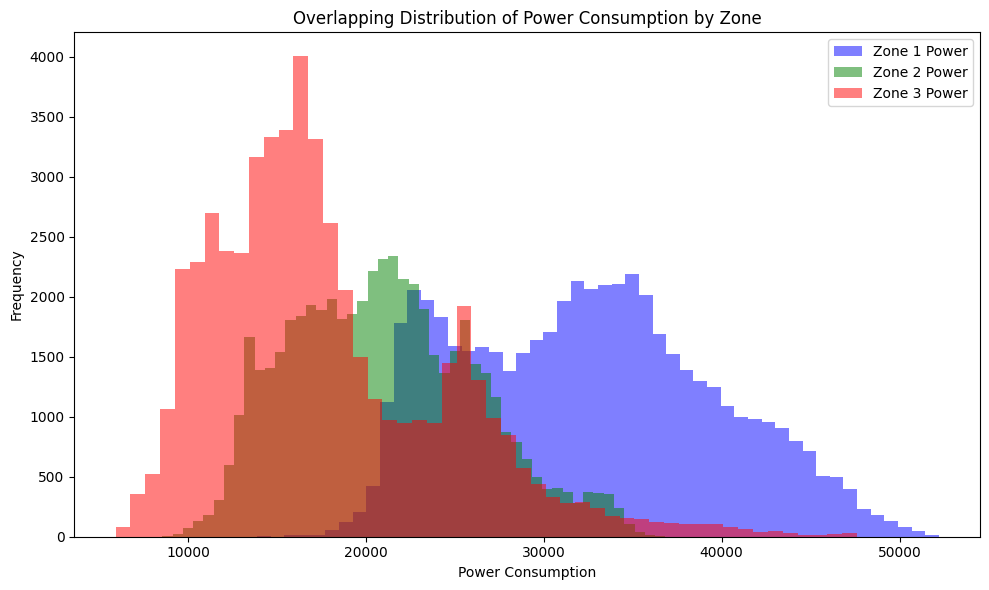

In [72]:
# Create an overlapping distribution chart for all three zones
fig, ax = plt.subplots(figsize=(10, 6))

# Zone 1 Power
ax.hist(tetoun_power["zone_1_power"], bins=50, alpha=0.5, label='Zone 1 Power', color='blue')

# Zone 2 Power
ax.hist(tetoun_power["zone_2_power"], bins=50, alpha=0.5, label='Zone 2 Power', color='green')

# Zone 3 Power
ax.hist(tetoun_power["zone_3_power"], bins=50, alpha=0.5, label='Zone 3 Power', color='red')

# Add titles and labels
ax.set_title('Overlapping Distribution of Power Consumption by Zone')
ax.set_xlabel('Power Consumption')
ax.set_ylabel('Frequency')
ax.legend()

plt.tight_layout()
plt.show()


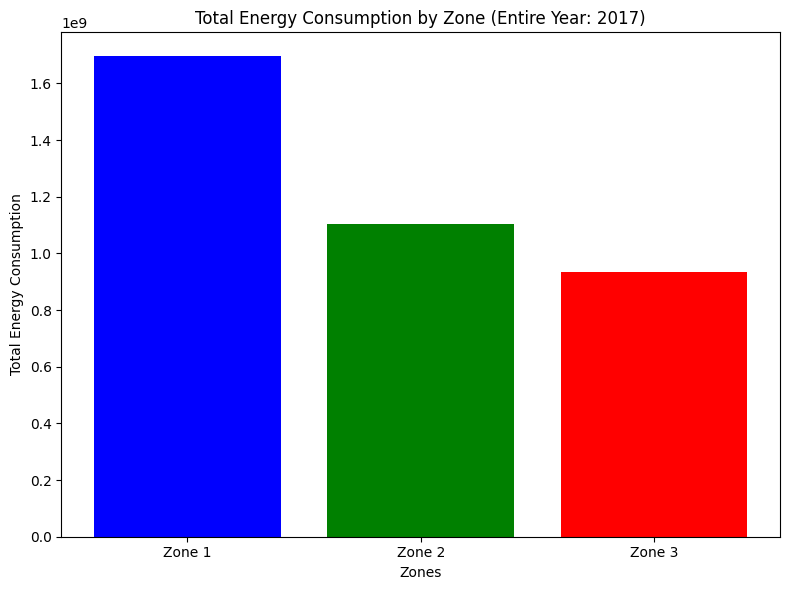

In [73]:
# Summing the total energy consumption for each zone over the entire year
total_consumption = {
    "Zone 1": tetoun_power["zone_1_power"].sum(),
    "Zone 2": tetoun_power["zone_2_power"].sum(),
    "Zone 3": tetoun_power["zone_3_power"].sum()
}

# Create a bar chart
fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(total_consumption.keys(), total_consumption.values(), color=['blue', 'green', 'red'])

# Add titles and labels
ax.set_title('Total Energy Consumption by Zone (Entire Year: 2017)')
ax.set_xlabel('Zones')
ax.set_ylabel('Total Energy Consumption')

# Display the bar chart
plt.tight_layout()
plt.show()

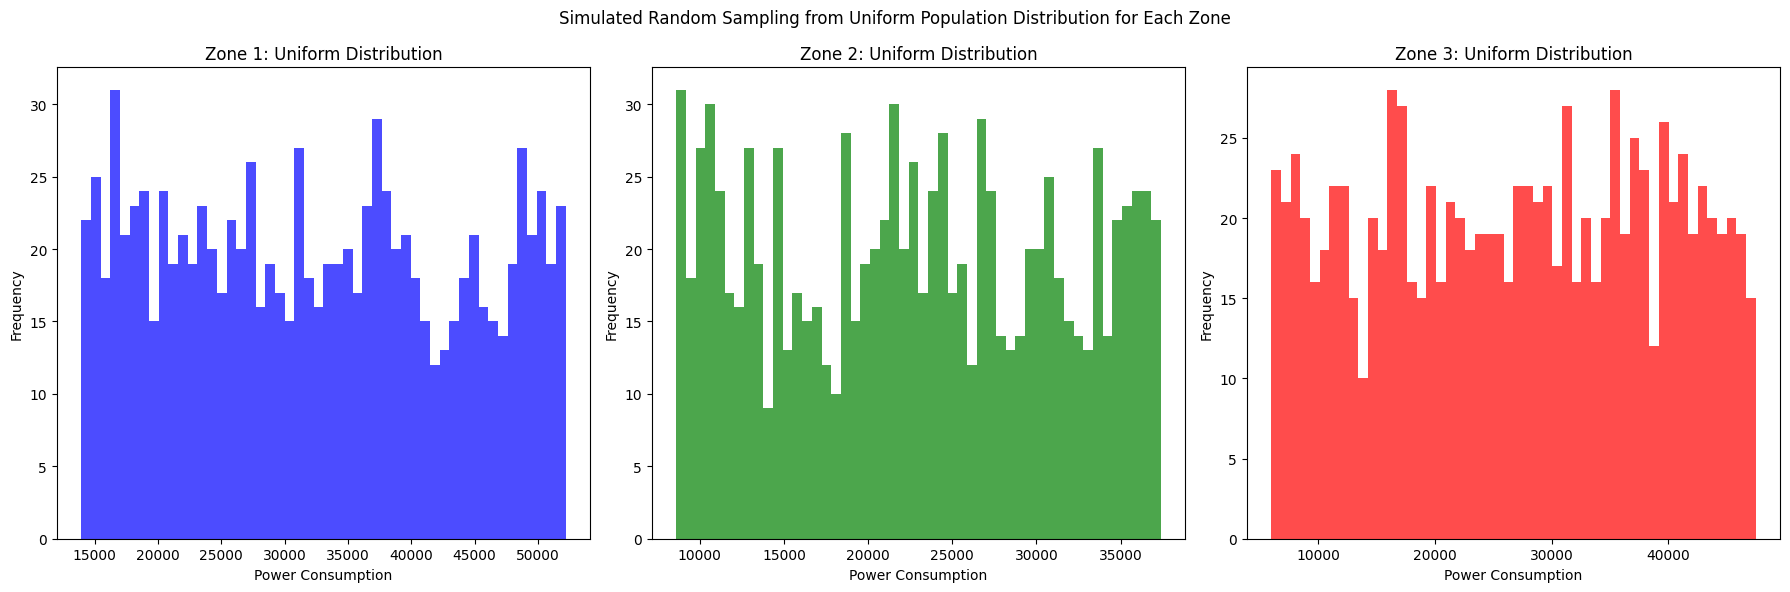

In [74]:
# Get the minimum and maximum power consumption values for each zone
zone_1_min, zone_1_max = tetoun_power["zone_1_power"].min(), tetoun_power["zone_1_power"].max()
zone_2_min, zone_2_max = tetoun_power["zone_2_power"].min(), tetoun_power["zone_2_power"].max()
zone_3_min, zone_3_max = tetoun_power["zone_3_power"].min(), tetoun_power["zone_3_power"].max()

# Simulate random sampling from a uniform distribution for each zone
num_samples = 1000  # Number of random samples

zone_1_samples = np.random.uniform(zone_1_min, zone_1_max, num_samples)
zone_2_samples = np.random.uniform(zone_2_min, zone_2_max, num_samples)
zone_3_samples = np.random.uniform(zone_3_min, zone_3_max, num_samples)

# Create histograms to visualize the uniform distribution for each zone
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Zone 1
ax[0].hist(zone_1_samples, bins=50, color='blue', alpha=0.7)
ax[0].set_title('Zone 1: Uniform Distribution')
ax[0].set_xlabel('Power Consumption')
ax[0].set_ylabel('Frequency')

# Zone 2
ax[1].hist(zone_2_samples, bins=50, color='green', alpha=0.7)
ax[1].set_title('Zone 2: Uniform Distribution')
ax[1].set_xlabel('Power Consumption')
ax[1].set_ylabel('Frequency')

# Zone 3
ax[2].hist(zone_3_samples, bins=50, color='red', alpha=0.7)
ax[2].set_title('Zone 3: Uniform Distribution')
ax[2].set_xlabel('Power Consumption')
ax[2].set_ylabel('Frequency')

# Display the charts
fig.suptitle('Simulated Random Sampling from Uniform Population Distribution for Each Zone')
plt.tight_layout()
plt.show()

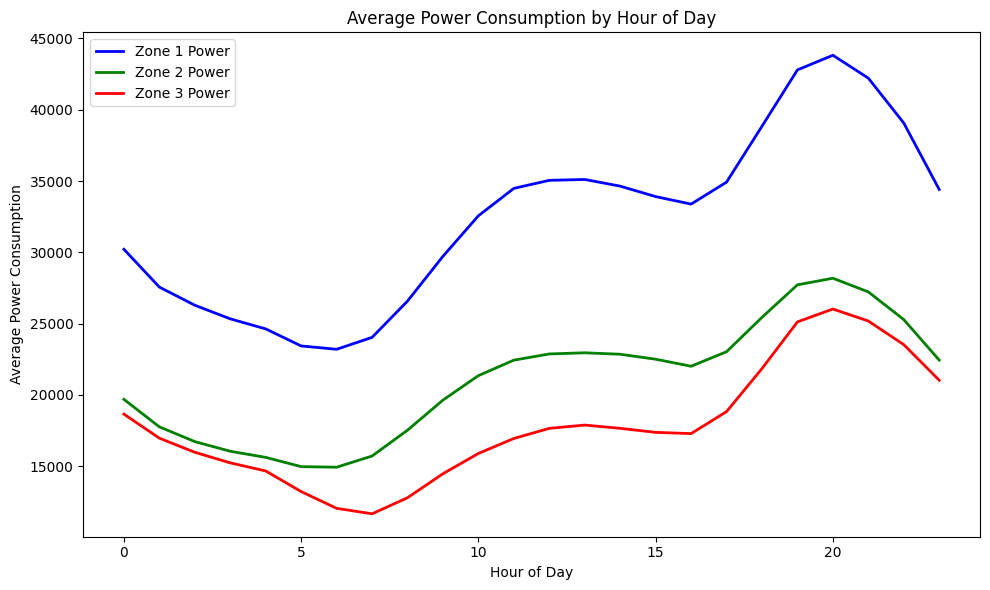

In [75]:
# Ensure the 'hour' column is created by extracting from the 'datetime' column
tetoun_power["hour"] = tetoun_power["datetime"].dt.hour

# Now we can group by 'hour' and calculate the mean power consumption
avg_power_by_hour = tetoun_power.groupby("hour")[["zone_1_power", "zone_2_power", "zone_3_power"]].mean()

# Plot the average power consumption by hour of the day with specific colors
plt.figure(figsize=(10, 6))
plt.plot(avg_power_by_hour.index, avg_power_by_hour["zone_1_power"], label="Zone 1 Power", color="blue", linewidth=2)
plt.plot(avg_power_by_hour.index, avg_power_by_hour["zone_2_power"], label="Zone 2 Power", color="green", linewidth=2)
plt.plot(avg_power_by_hour.index, avg_power_by_hour["zone_3_power"], label="Zone 3 Power", color="red", linewidth=2)

plt.xlabel('Hour of Day')
plt.ylabel('Average Power Consumption')
plt.title('Average Power Consumption by Hour of Day')
plt.legend()
plt.tight_layout()
plt.show()


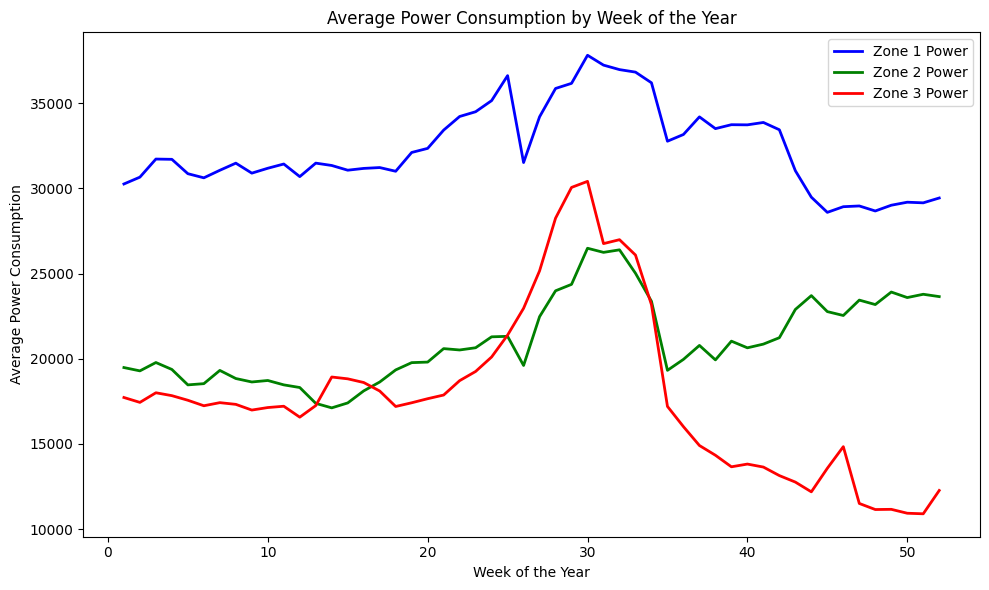

In [76]:
# Ensure the 'week' column is created by extracting from the 'datetime' column
tetoun_power["week"] = tetoun_power["datetime"].dt.isocalendar().week

# Group by 'week' and calculate the mean power consumption for each zone
avg_power_by_week = tetoun_power.groupby("week")[["zone_1_power", "zone_2_power", "zone_3_power"]].mean()

# Plot the average power consumption by week with specific colors for each zone
plt.figure(figsize=(10, 6))
plt.plot(avg_power_by_week.index, avg_power_by_week["zone_1_power"], label="Zone 1 Power", color="blue", linewidth=2)
plt.plot(avg_power_by_week.index, avg_power_by_week["zone_2_power"], label="Zone 2 Power", color="green", linewidth=2)
plt.plot(avg_power_by_week.index, avg_power_by_week["zone_3_power"], label="Zone 3 Power", color="red", linewidth=2)

# Add labels and title
plt.xlabel('Week of the Year')
plt.ylabel('Average Power Consumption')
plt.title('Average Power Consumption by Week of the Year')
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


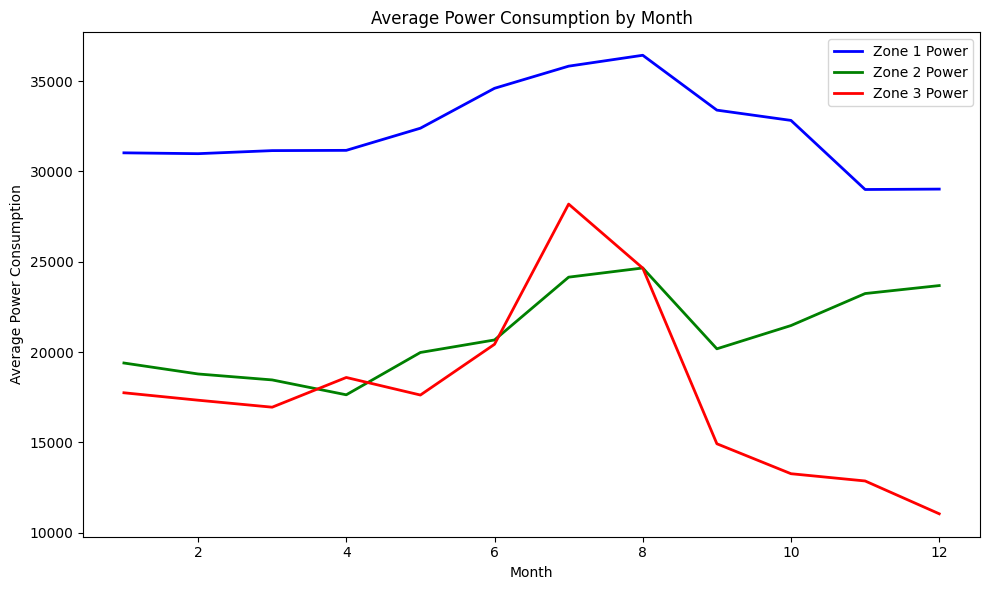

In [77]:
# Ensure the 'month' column is created by extracting from the 'datetime' column
tetoun_power["month"] = tetoun_power["datetime"].dt.month

# Group by 'month' and calculate the mean power consumption for each zone
avg_power_by_month = tetoun_power.groupby("month")[["zone_1_power", "zone_2_power", "zone_3_power"]].mean()

# Plot the average power consumption by month with specific colors for each zone
plt.figure(figsize=(10, 6))
plt.plot(avg_power_by_month.index, avg_power_by_month["zone_1_power"], label="Zone 1 Power", color="blue", linewidth=2)
plt.plot(avg_power_by_month.index, avg_power_by_month["zone_2_power"], label="Zone 2 Power", color="green", linewidth=2)
plt.plot(avg_power_by_month.index, avg_power_by_month["zone_3_power"], label="Zone 3 Power", color="red", linewidth=2)

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Average Power Consumption')
plt.title('Average Power Consumption by Month')
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


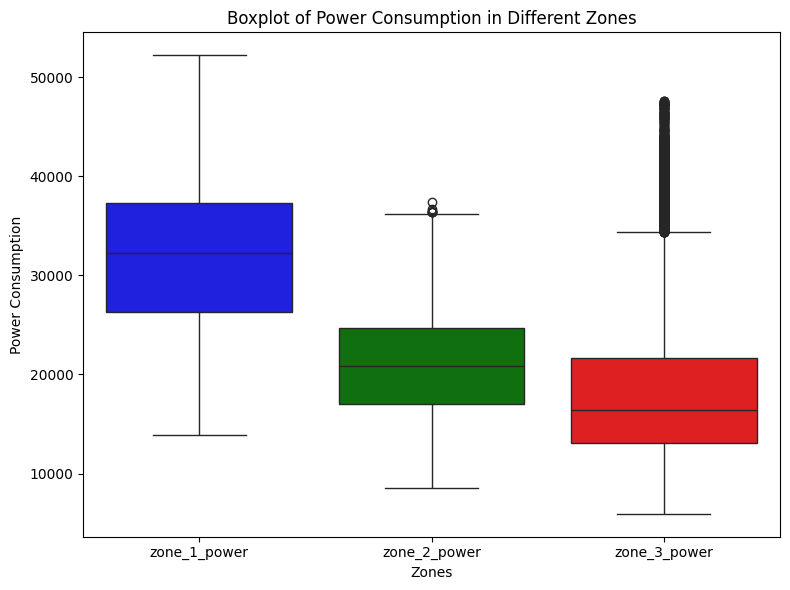

In [78]:
# Redoing the box plot with specific colors for each zone

plt.figure(figsize=(8, 6))

# Creating a boxplot and specifying the colors for each zone
sns.boxplot(data=tetoun_power[["zone_1_power", "zone_2_power", "zone_3_power"]],
            palette={"zone_1_power": "blue", "zone_2_power": "green", "zone_3_power": "red"})

plt.title('Boxplot of Power Consumption in Different Zones')
plt.xlabel('Zones')
plt.ylabel('Power Consumption')
plt.tight_layout()

# Display the plot
plt.show()


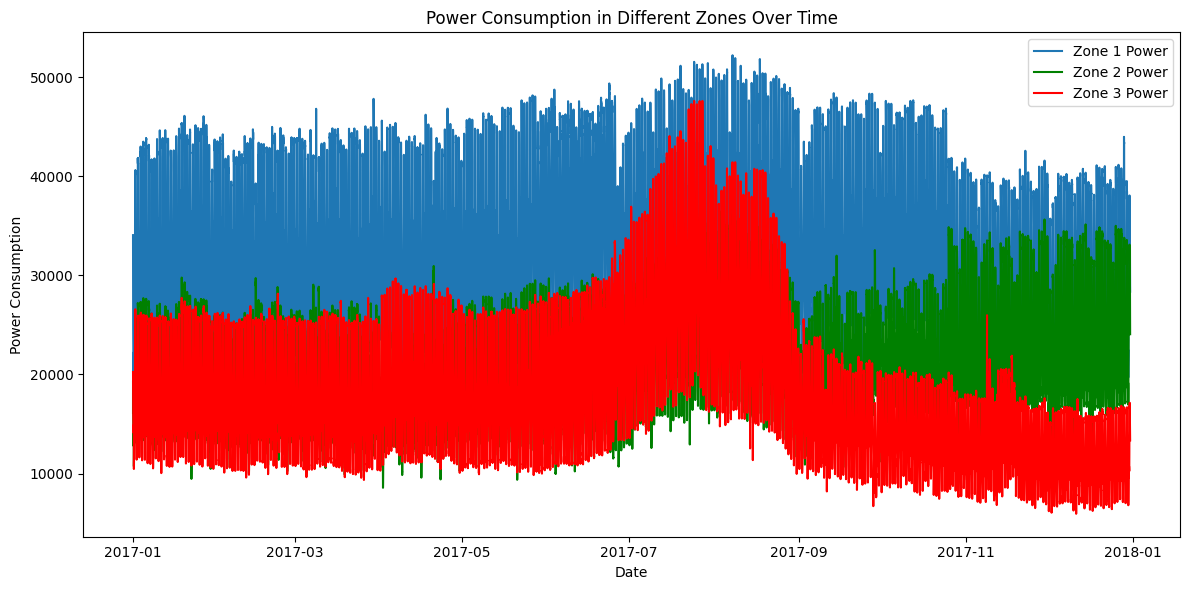

In [79]:
# Time series plot for power consumption in each zone
plt.figure(figsize=(12, 6))
plt.plot(tetoun_power["datetime"], tetoun_power["zone_1_power"], label="Zone 1 Power")
plt.plot(tetoun_power["datetime"], tetoun_power["zone_2_power"], label="Zone 2 Power", color="green")
plt.plot(tetoun_power["datetime"], tetoun_power["zone_3_power"], label="Zone 3 Power", color="red")
plt.xlabel('Date')
plt.ylabel('Power Consumption')
plt.title('Power Consumption in Different Zones Over Time')
plt.legend()
plt.tight_layout()
plt.show()


In [80]:
# Summary statistics for power consumption in each zone
summary_stats = tetoun_power[["zone_1_power", "zone_2_power", "zone_3_power"]].describe()
print(summary_stats)


       zone_1_power  zone_2_power  zone_3_power
count  52416.000000  52416.000000  52416.000000
mean   32344.970564  21042.509082  17835.406218
std     7130.562564   5201.465892   6622.165099
min    13895.696200   8560.081466   5935.174070
25%    26310.668692  16980.766032  13129.326630
50%    32265.920340  20823.168405  16415.117470
75%    37309.018185  24713.717520  21624.100420
max    52204.395120  37408.860760  47598.326360


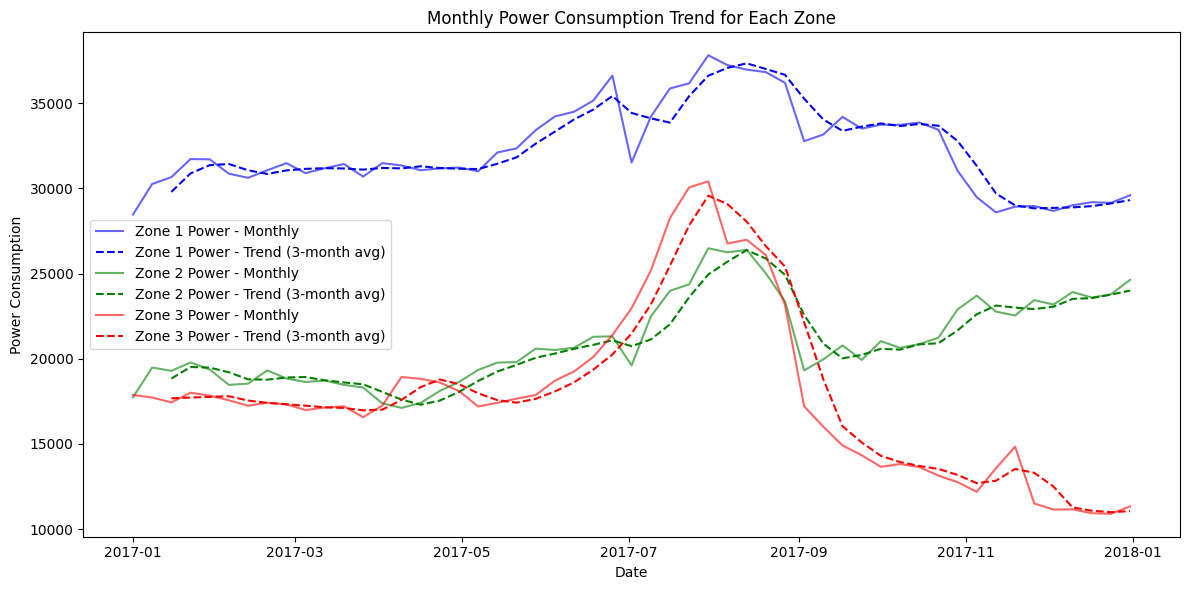

In [81]:
# Set 'datetime' as the index for time-based operations
tetoun_power.set_index('datetime', inplace=True)

# Resample the data to a monthly frequency and calculate the average power consumption per month
monthly_consumption = tetoun_power.resample('W').mean()[["zone_1_power", "zone_2_power", "zone_3_power"]]

# Calculate a 3-month rolling mean to smooth out short-term fluctuations
rolling_avg = monthly_consumption.rolling(window=3).mean()

# Plot the monthly average power consumption for each zone along with the rolling average
plt.figure(figsize=(12, 6))

# Zone 1
plt.plot(monthly_consumption.index, monthly_consumption["zone_1_power"], label="Zone 1 Power - Monthly", color="blue", alpha=0.6)
plt.plot(rolling_avg.index, rolling_avg["zone_1_power"], label="Zone 1 Power - Trend (3-month avg)", color="blue", linestyle="--")

# Zone 2
plt.plot(monthly_consumption.index, monthly_consumption["zone_2_power"], label="Zone 2 Power - Monthly", color="green", alpha=0.6)
plt.plot(rolling_avg.index, rolling_avg["zone_2_power"], label="Zone 2 Power - Trend (3-month avg)", color="green", linestyle="--")

# Zone 3
plt.plot(monthly_consumption.index, monthly_consumption["zone_3_power"], label="Zone 3 Power - Monthly", color="red", alpha=0.6)
plt.plot(rolling_avg.index, rolling_avg["zone_3_power"], label="Zone 3 Power - Trend (3-month avg)", color="red", linestyle="--")

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Power Consumption')
plt.title('Monthly Power Consumption Trend for Each Zone')
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

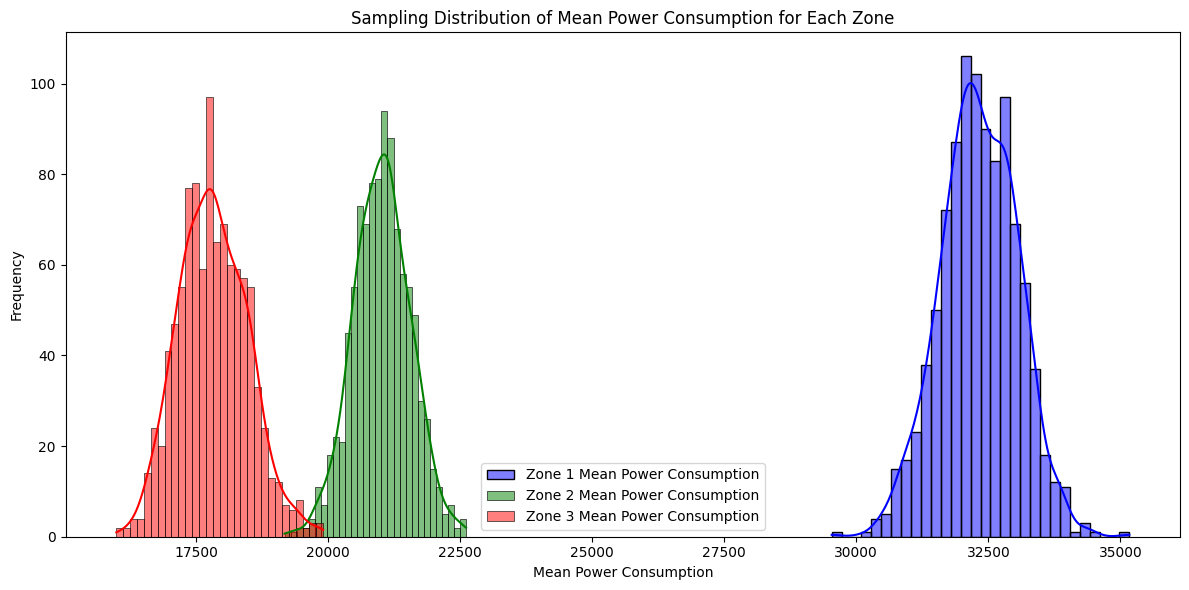

In [82]:
# Set the number of samples and sample size
num_samples = 1000  # Number of samples to draw
sample_size = 100    # Size of each sample

# Initialize lists to store the sample means for each zone
zone_1_sample_means = []
zone_2_sample_means = []
zone_3_sample_means = []

# Build the sampling distribution by drawing multiple samples
for _ in range(num_samples):
    sample = tetoun_power.sample(n=sample_size, replace=True)
    zone_1_sample_means.append(sample["zone_1_power"].mean())
    zone_2_sample_means.append(sample["zone_2_power"].mean())
    zone_3_sample_means.append(sample["zone_3_power"].mean())

# Plot the sampling distributions
plt.figure(figsize=(12, 6))

# Zone 1 sampling distribution
sns.histplot(zone_1_sample_means, bins=30, kde=True, color="blue", label="Zone 1 Mean Power Consumption")
# Zone 2 sampling distribution
sns.histplot(zone_2_sample_means, bins=30, kde=True, color="green", label="Zone 2 Mean Power Consumption")
# Zone 3 sampling distribution
sns.histplot(zone_3_sample_means, bins=30, kde=True, color="red", label="Zone 3 Mean Power Consumption")

# Add labels, title, and legend
plt.xlabel('Mean Power Consumption')
plt.ylabel('Frequency')
plt.title('Sampling Distribution of Mean Power Consumption for Each Zone')
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


In [121]:
# Hypothetical mean value to compare against
hypothetical_mean = 32300

# One-sample t-test for Zone 1 power consumption
t_statistic, p_value = stats.ttest_1samp(tetoun_power['zone_1_power'], hypothetical_mean)

print(f"""One-sample t-test for Zone 1 Power Consumption

Testing whether the mean power consumption in Zone 1 differs significantly from a hypothetical value, {hypothetical_mean} in this case.

H0:μ Zone1 = {hypothetical_mean}
H1:μ Zone1 >/< {hypothetical_mean}
""")
print(f"t-statistic: {t_statistic:.4f}, p-value: {p_value:.4f}")

# Interpretation
if p_value < 0.05:
    print("The result is statistically significant. We reject the null hypothesis.")
else:
    print("The result is not statistically significant. We fail to reject the null hypothesis.")


One-sample t-test for Zone 1 Power Consumption

Testing whether the mean power consumption in Zone 1 differs significantly from a hypothetical value, 32300 in this case.

H0:μ Zone1 = 32300
H1:μ Zone1 >/< 32300

t-statistic: 1.4439, p-value: 0.1488
The result is not statistically significant. We fail to reject the null hypothesis.


In [120]:
# Two-sample t-test between Zone 1 and Zone 2
t_statistic, p_value = stats.ttest_ind(tetoun_power['zone_1_power'], tetoun_power['zone_2_power'])

print(f"""Two-sample t-test between Zone 1 and Zone 2 Power Consumption

Testing whether the mean power consumption in Zone 1 is significantly different from that in Zone 2.

H0:μ Zone1 = μ Zone2
H1:μ Zone1 >/< μ Zone2
""")
print(f"t-statistic: {t_statistic:.4f}, p-value: {p_value:.4f}")

# Interpretation
if p_value < 0.05:
    print("The result is statistically significant. We reject the null hypothesis.")
else:
    print("The result is not statistically significant. We fail to reject the null hypothesis.")


Two-sample t-test between Zone 1 and Zone 2 Power Consumption

Testing whether the mean power consumption in Zone 1 is significantly different from that in Zone 2.

H0:μ Zone1 = μ Zone2
H1:μ Zone1 >/< μ Zone2

t-statistic: 293.1810, p-value: 0.0000
The result is statistically significant. We reject the null hypothesis.


In [123]:
# ANOVA test across Zone 1, Zone 2, and Zone 3
f_statistic, p_value = stats.f_oneway(tetoun_power['zone_1_power'], 
                                      tetoun_power['zone_2_power'], 
                                      tetoun_power['zone_3_power'])

print(f"""ANOVA test across Zone 1, Zone 2, and Zone 3 Power Consumption.

Test whether there is a significant difference in the mean power consumption across Zone 1, Zone 2, and Zone 3.

H0:μ Zone1 = μ Zone2 = μ Zone3
H1:At least one μ is different.
""")
print(f"F-statistic: {f_statistic:.4f}, p-value: {p_value:.4f}")

# Interpretation
if p_value < 0.05:
    print("The result is statistically significant. We reject the null hypothesis.")
else:
    print("The result is not statistically significant. We fail to reject the null hypothesis.")


ANOVA test across Zone 1, Zone 2, and Zone 3 Power Consumption.

Test whether there is a significant difference in the mean power consumption across Zone 1, Zone 2, and Zone 3.

H0:μ Zone1 = μ Zone2 = μ Zone3
H1:At least one μ is different.

F-statistic: 75028.9996, p-value: 0.0000
The result is statistically significant. We reject the null hypothesis.
